![STSCI banner](https://github.com/STScI-MIRI/MRS-ExampleNB/raw/main/assets/banner1.png)

# Introduction to TSO data products & the JWST TSO pipeline

Author: Sarah Kendrew, Instrument & Calibration Scientist, ESA/STScI MIRI Branch
Last Updated: 17 Nov 2021
Pipeline version: 1.3.3

### Table of contents

1. [Introduction](#intro)<br>
   1.1 [Purpose of this Notebook](#purpose)<br>
   1.2 [Input Simulations](#inputs)<br>
   1.3 [Caveats for Simulated Data](#mirisim)<br>





# 1.<font color='white'>-</font>Introduction <a class="anchor" id="intro"></a>

## 1.1<font color='white'>-</font>Purpose of this notebook <a class="anchor" id="purpose"></a>

In this notebook we provide a realistic example for running the JWST pipeline on a JWST Time Series Observation (TSO). For the purposes of this tutorial we will work with a simulated observation with the MIRI Low Resolution Spectrometer (LRS). In particular, we focus on aspects of the pipeline that differ from "standard" algorihtms and procedures. There will not be enough time to look at every step in detail, but we will demonstrate how to make changes to the pipeline setting (and why you might want to do that) for the best scientific utility. 

Note that the notebook uses JWST Calibration Pipeline version 1.3.3, which is the current version at the time of this JWebbinar. The pipeline will however be further developed and updated post-launch. 

We will start with a simple simulated MIRI LRS observation, created using MIRISim version 2.4.1, which is compatible with pipeline version 1.3.3 (https://wiki.miricle.org/Public/MIRISim_Public). The data are described in more detail below. 


## 1.2<font color='white'>-</font>Input Simulations <a class="anchor" id="inputs"></a>

We used the MIRISim software package (v2.4.1) to generate realistic simulations of a MIRI LRS slitless observation of a simple stellar-type point source. The stellar SED was modelled as a simple black body spectrum with the following parameters:

* Temperature = 6230 K
* Normalised to K = 8.99, or flux of 20 mJy at 2 $\mu$m. 

LRS slitless observations are carried out in the SLITLESSPRISM subarray of the MIRI Imaging detector. The subarray has 416 rows x 72 columns (the left-most 4 columns are reference pixels, i.e. no illuminated), with sampling of 0.11 arcsec/pix. The single-frame read time for this subarray is 0.159 seconds, and the FASTR1 read mode has an extra reset between integrations. We perform an observation of 100 groups, 10 integrations, in a single exposure; giving an exposure time of:

t$_{exp}$ = ((100 + 1) $\times$ 0.159) $\times$ 10 = 160.59 s = 2.67 minutes

"Real" TSOs will typically have many more integrations than 10, with exposures covering many hours. But for the sake of reducing processing time, we use a shorter exposure here. 



### 1.3<font color='white'>-</font>Caveats for Simulated Data<a class="anchor" id="mirisim"></a> ###

As noted above, in this notebook we will be processing simulated data created with the MIRIsim tool.  Like the pipeline, MIRISim is also an evolving piece of software and there are multiple known issues that can cause problems.  

**General MIRISim caveats**

- Detector noise properties are not modelled in a fully physically realistic way. It's not recommended to use these simulations "out of the box" for detailed noise investigations. 

- Reference pixels are not treated consistently, the refpix step of detector1 must therefore be turned off to process mirisim data without artifacts.

**MIRI TSO-specific caveats**

- There is no "TSO" flag in MIRISim; the software does not set the header keyword that the pipeline looks for to recignise whether an exposure is a TSO. We will set this manually in this notebook.

- MIRISim is not able to insert a time-variable signal into a simulated observation. The source flux is assumed to be constant. Additional tools have been developed in the MIRI consortium for this purpose, but for the aims of this tutorial we do not consider this. 

- The MIRI LRS prism has a leak in its transmission that causes some 3-4 $\mu$m flux to contaminate the spectrum around 6-7 $\mu$m. This is not included in the MIRISim models. 




<hr style="border:1px solid gray"> </hr>

## 2.<font color='white'>-</font>Setup <a class="anchor" id="setup"></a>

In this section we set things up a number of necessary things in order for the pipeline to run successfully:

1. import the necessary python packages
2. specify the directory structure

First the imports.


In [37]:
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import astropy.io.fits as fits
from astropy.utils.data import download_file

from jwst import datamodels
from jwst.pipeline import Detector1Pipeline, Spec2Pipeline, Tso3Pipeline
from jwst.associations.asn_from_list import asn_from_list
from gwcs.wcstools import grid_from_bounding_box

Next we will create an output directory for the new products we produce. 

In [7]:
outdir = 'miri_lrs_output'
if not os.path.exists(outdir):
    os.mkdir(outdir)


<hr style="border:1px solid gray"> </hr>

## 3.<font color='white'>-</font>Retrieving and Inspecting the Uncalibrated Data <a class="anchor" id="firstlook"></a>

In practice, you will retrieve your observational data from the [MAST archive portal](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html). Here you can query on a host a different parameters - mission, instrument, program ID, date of execution, etc. 

In the archive you will find both uncalibrated and calibrated data. All data received from the observatory is automatically processed by the current pipeline version; this includes ancillary data such as target acquisition images. The steps that are run in the pipeline for a particular data mode can be found in the pipeline documentation for [Stage 1](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html#calwebb-detector1), [Stage 2](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html) and [Stage 3](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_tso3.html). 

This automated pipeline processing uses a set of default parameters that were determined by the instrument teams to be "good" for a typical observation, however, some observers may want to try out different settings or find better settings for their particular science case. We will show later how this works. 

For the purposes of this JWebbinar we provide a simulated observation. 


In [11]:
f = 'miri_lrs_tso_100G10I_mirisim241.fits'
#f = '/home/shared/preloaded-fits/miri_lrs_tso_100G10I_mirisim241.fits'

You can access this file and examine structure & contents using regular astropy FITS tools, like this. You can see the file has 5 extensions:

* An empty primary extension (with a header)
* SCI: the science data. This is a 4D dataset: NCOLS x NROWS x NGROUPS x NINTS. 
* PIXELDQ: data quality flags. This is a single 2D plane with dimensions NCOLS x NROWS.
* REFOUT: the MIRI reference output values. This is a MIRI specific output. 
* ASDF: the metadata for the datamodels. 

Note that normally the PXELDQ plane is added in the first pipeline stage; its presence here is a feature of MIRISIm. Only the reference columns are flagged, the rest of this array is zeros. 

_Note to Sarah: what is the pixel DQ flag 16777217 in that 5th column of the DQ array?_

In [16]:
hdu = fits.open(f)
hdu.info()

Filename: miri_lrs_tso_100G10I_mirisim241.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     117   ()      
  1  SCI           1 ImageHDU        51   (72, 416, 100, 10)   float32   
  2  PIXELDQ       1 ImageHDU        11   (72, 416)   int32 (rescales to uint32)   
  3  REFOUT        1 ImageHDU        11   (18, 416, 100, 10)   float32   
  4  ASDF          1 BinTableHDU     11   1R x 1C   [5829B]   


Using matplotlib, we can visualize the data. The first plot below shows groups 25, 50 and 100 of the first integration of the exposure. You can see how the signal builds up with increasing group number. This increase in signal forms the ''ramp'' that the pipeline will be fitting. 

The second plot shows this flux build up in 2 pixels: one in the source spectrum, and one in the background. 

_Note SK: make this figure look prettier_

(10, 100, 416, 72)


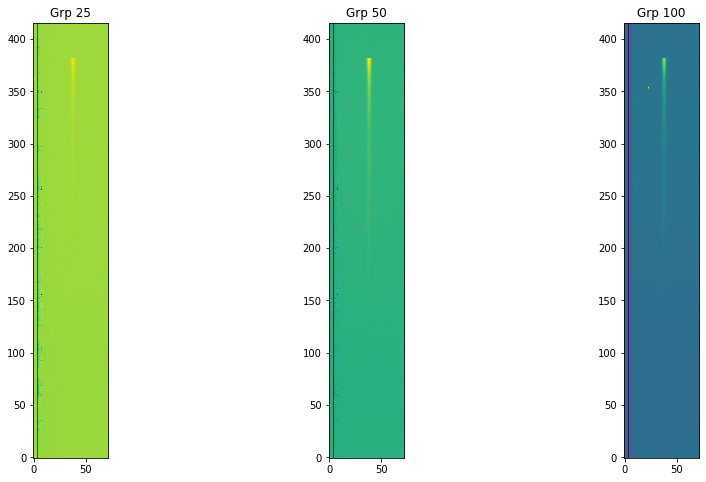

In [34]:
uncal_fits = hdu[1].data
print(np.shape(uncal_fits))

nints = np.shape(uncal_fits)[0]

ql_fig, ax = plt.subplots(ncols=3, nrows=1, figsize=[15,8])
plt_ints = [24, 49, 99]

for i, pi in enumerate(plt_ints):
    ax[i].imshow(uncal_fits[8, pi, :, :], origin='lower', aspect='equal', interpolation='None')
    ax[i].set_title('Grp {}'.format(pi+1))




2021-11-19 15:03:28,995 - stpipe - WARNING - /var/folders/9l/lthyqbnd6md29c4bpkgdp_980001p3/T/ipykernel_97354/1204688972.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  ramp_fig.show()



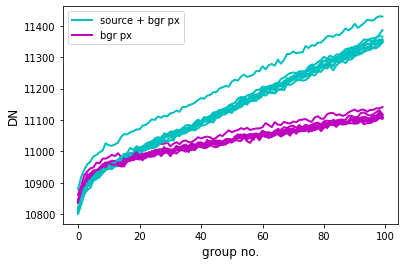

In [45]:
src_px = [35, 360]
bgr_px = [15, 200]

ramp_fig, ax = plt.subplots()
for i in range(nints):
    ax.plot(uncal_fits[i,:,src_px[1], src_px[0]], 'c-', lw=2)
    ax.plot(uncal_fits[i,:,bgr_px[1], bgr_px[0]], 'm-', lw=2)

leg = [Line2D([0], [0], lw=2, color='c', label='source + bgr px'), 
       Line2D([0], [0], lw=2, color='m', label='bgr px')]   
    
ax.set_xlabel('group no.', fontsize='large')
ax.set_ylabel('DN', fontsize='large')
ax.legend(handles=leg, loc=2, fontsize='medium')

ramp_fig.show()


### 3.1 Introduction to JWST datamodels

The JWST Calibration Pipeline ("the pipeline") provides datamodels for convenient accessing and working with the data. These datamodels are effectively containers that are optimised for particular JWST data types. More information is available [here](https://jwst-pipeline.readthedocs.io/en/latest/jwst/datamodels/index.html).

You don't need to know what specific model your data corresponds to. The ``datamodels.open`` function checks the relevant header keywords and matches the data against an existing model. 

In the cells below we will explore come useful aspects of the datamodels. 

In [51]:
uncal = datamodels.open(f)
print(uncal)
print(uncal.info())


<RampModel(10, 100, 416, 72) from miri_lrs_tso_100G10I_mirisim241.fits>
root (AsdfObject)
├─asdf_library (Software) ...
├─history (dict) ...
├─_fits_hash (str): fb7f90ed45c8c3bfce233dde22f04ef8a93501d6199ac41c24f9755bf787b342
├─columns (int): 72
├─data (NDArrayType): shape=(10, 100, 416, 72), dtype=float32
├─groupgap (int): 0
├─grpavg (int): 1
├─include_err (bool): False
├─include_groupdq (bool): False
├─include_pixeldq (bool): True
├─intavg (int): 1
├─maskwith (str): pixeldq
├─meta (dict) ...
├─nframes (int): 1
├─ngroups (int): 100
├─ngroups_file (int): 100
├─nints (int): 10
├─nints_file (int): 10
├─noerr (bool): True
├─pixeldq (ndarray): shape=(416, 72), dtype=uint32
├─rampdata (bool): True
└─7 not shown
Some nodes not shown.
None


This schema gives us a first look at the the model attributes, and how the metadata is packaged in the model. Most importantly, the science data is in the ``uncal.data`` attribute.  If you aren't sure where to find a particular keyword, the function ``uncal.find_fits_keyword`` can identify it for you. 

In [57]:
print('The number of groups per integration in the exposure is {0}'.format(uncal.ngroups))
print('The number of integrations in the exposure is {0}'.format(uncal.nints))
print('Information on the filter used in this exposure can be found here: {0}'.format(uncal.find_fits_keyword('FILTER')))
print('OK! So the filter used is {0}'.format(uncal.meta.instrument.filter))



The number of groups per integration in the exposure is 100
The number of integrations in the exposure is 10
Information on the filter used in this exposure can be found here: ['meta.instrument.filter']
OK! So the filter used is P750L


We can recreate the above plot using datamodel syntax

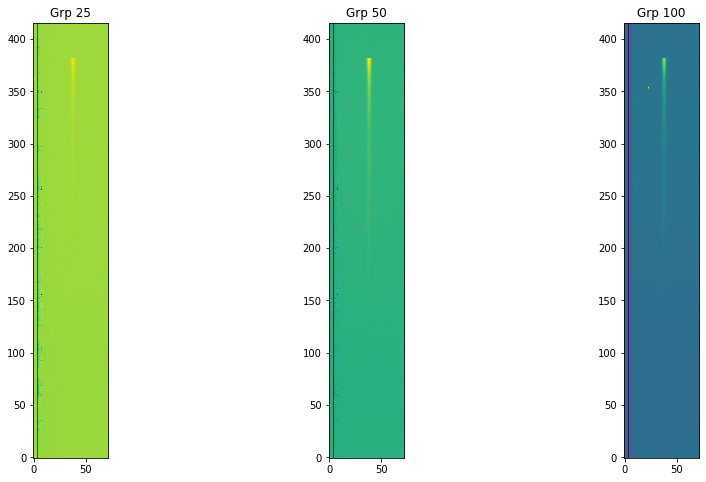

In [59]:
ql_fig2, ax2 = plt.subplots(ncols=3, nrows=1, figsize=[15,8])
plt_ints = [24, 49, 99]

for i, pi in enumerate(plt_ints):
    ax2[i].imshow(uncal.data[8, pi, :, :], origin='lower', aspect='equal', interpolation='None')
    ax2[i].set_title('Grp {}'.format(pi+1))



The ``meta`` attribute of the model is particular rich in unseful information. We'll show some of its useful features in the next cell. Not all attributes of the model are correctly populated as the MIRISim simulation data lacks some of the JWST observatory keywords. 


We show here that the "TSOVISIT" keyword or attribute is not set. This is a MIRISim issue, and we'll show below how we set this manually in the data model to ensure that the pipeline recognizes the exposure as a TSO.

In [81]:
print('Total exposure time is {:.2f} seconds'.format(uncal.meta.exposure.exposure_time))
print('Detector readout pattern was {0} mode'.format(uncal.meta.exposure.readpatt))      
print('The original filename of this RampModel was {0}'.format(uncal.meta.filename))     
print('The most amazing space telescope bar none is {0}'.format(uncal.meta.telescope))   
print('TSOs should have this attribute set to True and instead it reads {0}'.format(uncal.meta.visit.tsovisit))

# Let's change the TSO status
if not uncal.meta.visit.tsovisit:
    uncal.meta.visit.tsovisit = True

print('Now the TSO setting reads {0}'.format(uncal.meta.visit.tsovisit))


Total exposure time is 159.04 seconds
Detector readout pattern was FAST mode
The original filename of this RampModel was miri_lrs_tso_100G10I_mirisim241.fits
The most amazing space telescope bar none is JWST
TSOs should have this attribute set to True and instead it reads True
Now the TSO setting reads True


### Summary and further reading

In this section, we:
* loaded the uncalibrated MIRISim data for a slitless LRS exposure
* showed how to load the data using datamodels
* showed some of the useful features of datamodels and how metadata is organised in the model attributes
    
    
Further reading
*


